In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn, optim
import numpy
import h5py
import os
import sys
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
sys.path.append(os.path.abspath(os.path.join('..')))

In [33]:
%matplotlib notebook
from data.synthetic_generator import synthetic3D
from utils.training import train_mixture
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel

fmri_dataset = 'data/dataset/dataset_all_subjects_LEiDA.hdf5'

### Generetate Synthetic 3D dataset

In [12]:
sig1 = torch.diag(torch.tensor([1, 1e-3, 1e-3]))
sig2 = torch.eye(3) + 0.9 * (torch.ones(3) - torch.eye(3))
sig3 = torch.diag(torch.tensor([1e-3, 1, 1])) \
       + 0.9 * torch.tensor([[0, 0, 0], [0, 0, 1], [0, 1, 0]])

SIGMAs = torch.stack([sig1, sig2, sig3], dim=0)
print(SIGMAs, '\n-----------')

PI = [0.6, 0.2, 0.2]


X, cluster_id = synthetic3D(pi=PI, Sigmas=SIGMAs, num_points=3000, as_array=False)

print(X.shape)

tensor([[[1.0000, 0.0000, 0.0000],
         [0.0000, 0.0010, 0.0000],
         [0.0000, 0.0000, 0.0010]],

        [[1.0000, 0.9000, 0.9000],
         [0.9000, 1.0000, 0.9000],
         [0.9000, 0.9000, 1.0000]],

        [[0.0010, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.9000],
         [0.0000, 0.9000, 1.0000]]]) 
-----------
Simulate 3000 point from 3 of clusters
Generating Synthetic HMM sequence
torch.Size([3000, 3])


#### Train on Synthectic data

In [4]:
def get_param(model, show=True):
    para = model.get_mixture_param()
    
    if show:
        for p_k in para:
            print(p_k)
            print(para[p_k])
            print(10*'---')
    
    return para

In [43]:
ACGmixture = TorchMixtureModel(ACG, K=3, dist_dim=3)
_ = get_param(ACGmixture)

Adam_optimizer = optim.Adam(ACGmixture.parameters(), lr=0.01)

epoch_likelihood = train_mixture(ACGmixture, data=X, optimizer=Adam_optimizer, num_epoch=500)

_ = get_param(ACGmixture)

plt.plot(epoch_likelihood)
print(f'Min LL: {epoch_likelihood[-1]}')

pi
tensor([0.9827, 0.6939, 0.3258])
------------------------------
mix_comp_0
tensor([[0.3538, 0.1971, 0.3009],
        [0.1971, 1.0636, 0.8555],
        [0.3009, 0.8555, 1.3203]])
------------------------------
mix_comp_1
tensor([[ 0.0872, -0.0530,  0.1912],
        [-0.0530,  0.6622,  1.0627],
        [ 0.1912,  1.0627,  2.7310]])
------------------------------
mix_comp_2
tensor([[ 0.2357, -0.6038, -0.1038],
        [-0.6038,  1.5548,  0.3136],
        [-0.1038,  0.3136,  0.9016]])
------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.13it/s]

pi
tensor([0.0112, 0.0900, 1.7160])
------------------------------
mix_comp_0
tensor([[ 3.1212e-03, -2.7839e-05, -1.1203e-04],
        [-2.7839e-05,  6.5456e-01,  1.2860e+00],
        [-1.1203e-04,  1.2860e+00,  5.4787e+00]])
------------------------------
mix_comp_1
tensor([[0.1069, 0.0576, 0.2458],
        [0.0576, 0.1563, 0.4075],
        [0.2458, 0.4075, 1.8947]])
------------------------------
mix_comp_2
tensor([[ 1.3031e+00, -2.1743e-02,  5.8756e-02],
        [-2.1743e-02,  1.5912e-03, -1.0396e-03],
        [ 5.8756e-02, -1.0396e-03,  4.0049e-03]])
------------------------------


TypeError: Axes3D.plot() missing 1 required positional argument: 'ys'

<IPython.core.display.Javascript object>


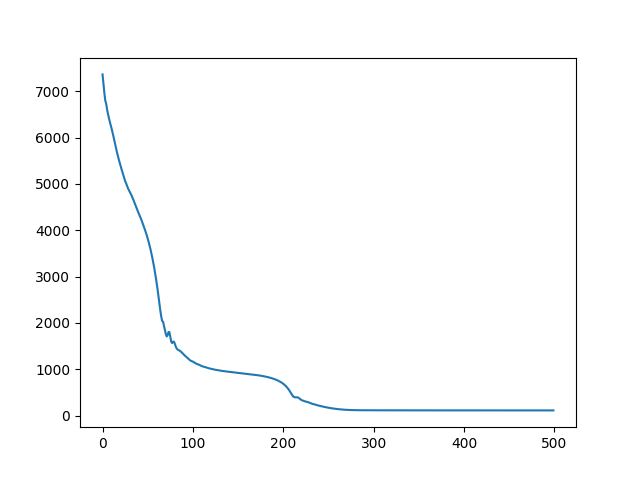

In [46]:
plt.clf()
%matplotlib notebook
plt.plot(epoch_likelihood)
plt.show()

## Test fitting

In [47]:
param = get_param(ACGmixture)

pi
tensor([0.0112, 0.0900, 1.7160])
------------------------------
mix_comp_0
tensor([[ 3.1212e-03, -2.7839e-05, -1.1203e-04],
        [-2.7839e-05,  6.5456e-01,  1.2860e+00],
        [-1.1203e-04,  1.2860e+00,  5.4787e+00]])
------------------------------
mix_comp_1
tensor([[0.1069, 0.0576, 0.2458],
        [0.0576, 0.1563, 0.4075],
        [0.2458, 0.4075, 1.8947]])
------------------------------
mix_comp_2
tensor([[ 1.3031e+00, -2.1743e-02,  5.8756e-02],
        [-2.1743e-02,  1.5912e-03, -1.0396e-03],
        [ 5.8756e-02, -1.0396e-03,  4.0049e-03]])
------------------------------


#### Simulate based on learned parameters

In [48]:
## Synthectic as np array
synX, syn_cluster_id = synthetic3D(pi=PI, Sigmas=SIGMAs, num_points=3000, as_array=True)

Simulate 3000 point from 3 of clusters


In [67]:
learned_sigma = torch.stack([param[f'mix_comp_{idx}'] for idx in range(ACGmixture.K)])

learned_pi = nn.functional.softmax(param['pi'].to(torch.float64), dim=0).to(torch.float32)
LearnX, Learn_cluster_id = synthetic3D(pi=learned_pi, Sigmas=learned_sigma, num_points=3000, as_array=True)

Simulate 3000 point from 3 of clusters


# Plot of Synthetic vs Learned Mixture Parameters

<IPython.core.display.Javascript object>


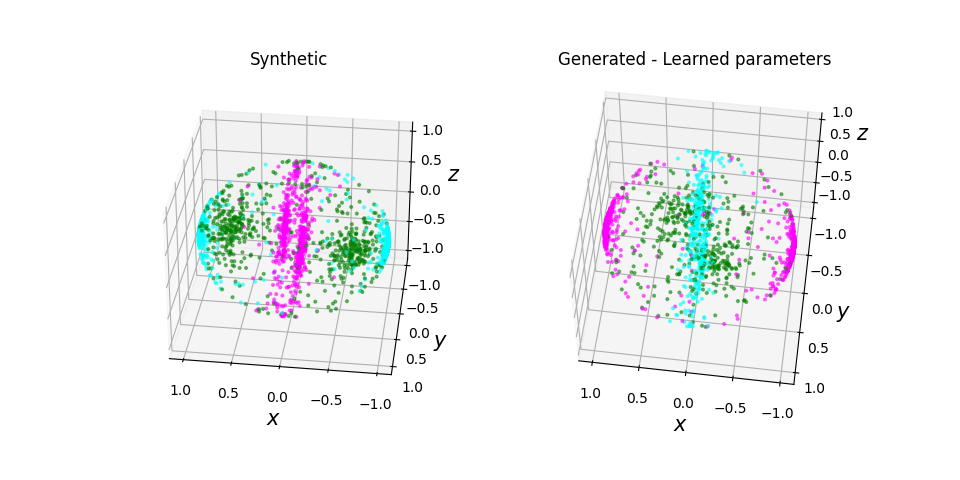

In [68]:
fig = plt.figure(figsize=plt.figaspect(0.5))
id_2_color = {0: 'cyan', 1: 'green', 2: 'magenta'}

# Synthetic
ax = fig.add_subplot(1, 2, 1, projection='3d')
label_color = [id_2_color[id] for id in syn_cluster_id]
ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Synthetic')
ax.view_init(30, 135)

# Learned
ax = fig.add_subplot(1, 2, 2, projection='3d')
label_color = [id_2_color[id] for id in Learn_cluster_id]
ax.scatter(LearnX[:, 0], LearnX[:, 1], LearnX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Generated - Learned parameters')
ax.view_init(30, 135)
plt.show()